# WUT MiNI Machine Learning on Graphs 2022/2023 Summer Project Demo

Cleora is a Python implementation of the Cleora algorithm for node embedding. The algorithm is described in the paper [Cleora: A Fast and Scalable Algorithm for Node Embedding](https://arxiv.org/pdf/2102.02302.pdf).

In [1]:
!pip --version

pip 21.2.3 from /Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/pip (python 3.9)


In [2]:
!pip install numpy scikit-learn networkx matplotlib

You should consider upgrading via the '/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/bin/python -m pip install --upgrade pip' command.


## Generate synthetic graphs

In [7]:
import networkx as nx

def generate_path_graph(num_paths: int, path_length: int) -> nx.Graph:
    """Generate a path graph"""
    graph = nx.path_graph(num_paths * path_length)
    for i in range(num_paths):
        graph = nx.contracted_nodes(graph, i * path_length, i * path_length + 1)
    return graph

def generate_cycle_graph(cycle_length: int) -> nx.Graph:
    """Generate a cycle graph"""
    graph = nx.cycle_graph(cycle_length)
    return graph

def generate_stochastic_block_model_graph(num_nodes: int = 100) -> nx.Graph:
    """Generate a stochastic block model graph"""
    block_sizes = [50, 50]
    block_probabilities = [[0.7, 0.1], [0.1, 0.7]]
    graph = nx.stochastic_block_model(
        block_sizes, block_probabilities, seed=42, directed=False
    )
    return graph

def generate_random_disconnected_graph(num_nodes: int) -> nx.Graph:
    """Generate a random disconnected graph"""
    graph = nx.gnm_random_graph(num_nodes, num_nodes * 2, seed=42, directed=False)
    return graph

def write_graph_to_file_as_edgelist(graph: nx.Graph, filename: str) -> None:
    """Write a graph to a file as an edgelist"""
    nx.write_edgelist(graph, filename, data=False)

GRAPHS = {
    "path": generate_path_graph(1, 10),
    "parallel_paths": generate_path_graph(10, 10),
    "cycle": generate_cycle_graph(10),
    "stochastic_block_model": generate_stochastic_block_model_graph(100),
    "random_disconnected": generate_random_disconnected_graph(100),
}

for graph_name, graph in GRAPHS.items():
    write_graph_to_file_as_edgelist(graph, f"../data/graphs/{graph_name}.txt")

## Run the script

In [8]:
import subprocess

SCRIPT_PATH = "../src/main.py"
DATA_DIR = "../data"

class CleoraConfig:
    """Configuration for the Cleora algorithm"""
    def __init__(self, input_filename: str, algorithm_version: str, num_dimensions: int, num_iterations: int=None):
        self.input_filename = input_filename
        self.algorithm_version = algorithm_version
        self.num_dimensions = num_dimensions
        self.num_iterations = num_iterations

    @property
    def input_filepath(self) -> str:
        """Get the input filepath"""
        return f"{DATA_DIR}/graphs/{self.input_filename}.txt"
    
    @property
    def output_filepath(self) -> str:
        """Get the output filepath"""
        output_filename = f"{self.input_filename}_{self.algorithm_version}"
        if self.algorithm_version == "fixed":
            output_filename += f"_i{self.num_iterations}_d{self.num_dimensions}"
        elif self.algorithm_version == "neighbourhood_depth":
            output_filename += f"_d{self.num_dimensions}"
        else:
            raise ValueError(f"Invalid algorithm_version version: {self.algorithm_version}")
        return f"{DATA_DIR}/embeddings/{output_filename}.txt"
    
    def get_rendered_script_params(self) -> str:
        """Get the parameters for the Cleora algorithm as a string"""
        if self.algorithm_version == "fixed":
            return f'--algorithm-version="{self.algorithm_version}" --input-filepath="{self.input_filepath}" --output-filepath="{self.output_filepath}" --num-dimensions {self.num_dimensions} --num-iterations {self.num_iterations}'
        elif self.algorithm_version == "neighbourhood_depth":
            return f'--algorithm-version="{self.algorithm_version}" --input-filepath="{self.input_filepath}" --output-filepath="{self.output_filepath}" --num-dimensions {self.num_dimensions}'
        else:
            raise ValueError(f"Invalid algorithm_version version: {self.algorithm_version}")
        
    def get_plot_label(self) -> str:
        """Get the label for the plot"""
        def get_params_description():
            if self.algorithm_version == "fixed":
                return f"i={self.num_iterations}, d={self.num_dimensions}"
            elif self.algorithm_version == "neighbourhood_depth":
                return f"d={self.num_dimensions}"
            else:
                raise ValueError(f"Invalid algorithm_version version: {self.algorithm_version}")
            
        return f"{self.algorithm_version} ({get_params_description()})"
    
# Define the configurations to run
CONFIGS = {
    "triangle": [
        CleoraConfig(input_filename="triangle", algorithm_version="fixed", num_dimensions=10, num_iterations=3),
        CleoraConfig(input_filename="triangle", algorithm_version="neighbourhood_depth", num_dimensions=10),
    ],
    "path": [
        CleoraConfig(input_filename="path", algorithm_version="fixed", num_dimensions=10, num_iterations=3),
        CleoraConfig(input_filename="path", algorithm_version="neighbourhood_depth", num_dimensions=10),
    ],
    "parallel_paths": [
        CleoraConfig(input_filename="parallel_paths", algorithm_version="fixed", num_dimensions=10, num_iterations=3),
        CleoraConfig(input_filename="parallel_paths", algorithm_version="neighbourhood_depth", num_dimensions=10),
    ],
    "cycle": [
        CleoraConfig(input_filename="cycle", algorithm_version="fixed", num_dimensions=10, num_iterations=3),
        CleoraConfig(input_filename="cycle", algorithm_version="neighbourhood_depth", num_dimensions=10),
    ],
    "stochastic_block_model": [
        CleoraConfig(input_filename="stochastic_block_model", algorithm_version="fixed", num_dimensions=10, num_iterations=3),
        CleoraConfig(input_filename="stochastic_block_model", algorithm_version="neighbourhood_depth", num_dimensions=10),
    ],
    "random_disconnected": [
        CleoraConfig(input_filename="random_disconnected", algorithm_version="fixed", num_dimensions=10, num_iterations=3),
        CleoraConfig(input_filename="random_disconnected", algorithm_version="neighbourhood_depth", num_dimensions=10),
    ],
    "facebook": [
        CleoraConfig(input_filename="facebook", algorithm_version="fixed", num_dimensions=10, num_iterations=1),
        CleoraConfig(input_filename="facebook", algorithm_version="fixed", num_dimensions=100, num_iterations=1),
        CleoraConfig(input_filename="facebook", algorithm_version="fixed", num_dimensions=10, num_iterations=7),
        CleoraConfig(input_filename="facebook", algorithm_version="fixed", num_dimensions=100, num_iterations=7),
    ]
}

def run_script(config: CleoraConfig, script_path=SCRIPT_PATH, dry_run=False) -> None:
    """Run a script with the given parameters"""
    rendered_script_params = config.get_rendered_script_params()
    command = f"python {script_path} {rendered_script_params}"
    print(f"Running command: {command}")
    if not dry_run:
        subprocess.run(command, shell=True)

config_flattened = [config for config_list in CONFIGS.values() for config in config_list]

for config in config_flattened:
    run_script(config)

Running command: python ../src/main.py --algorithm-version="fixed" --input-filepath="../data/graphs/triangle.txt" --output-filepath="../data/embeddings/triangle_fixed_i3_d10.txt" --num-dimensions 10 --num-iterations 3
Running command: python ../src/main.py --algorithm-version="neighbourhood_depth" --input-filepath="../data/graphs/triangle.txt" --output-filepath="../data/embeddings/triangle_neighbourhood_depth_d10.txt" --num-dimensions 10
Running command: python ../src/main.py --algorithm-version="fixed" --input-filepath="../data/graphs/path.txt" --output-filepath="../data/embeddings/path_fixed_i3_d10.txt" --num-dimensions 10 --num-iterations 3
Running command: python ../src/main.py --algorithm-version="neighbourhood_depth" --input-filepath="../data/graphs/path.txt" --output-filepath="../data/embeddings/path_neighbourhood_depth_d10.txt" --num-dimensions 10
Running command: python ../src/main.py --algorithm-version="fixed" --input-filepath="../data/graphs/parallel_paths.txt" --output-fil

## Visualize the graphs

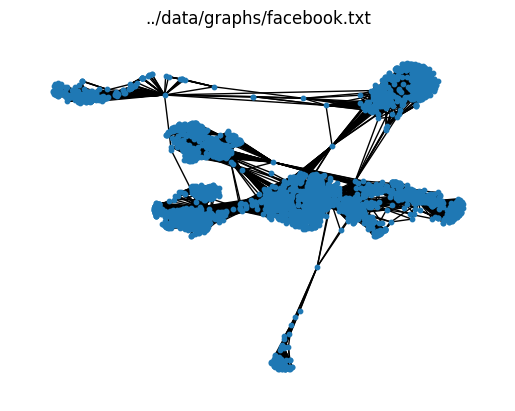

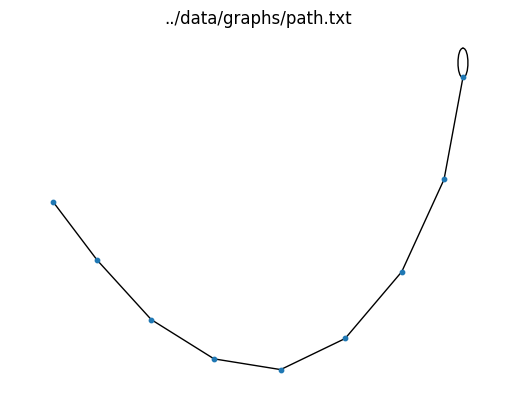

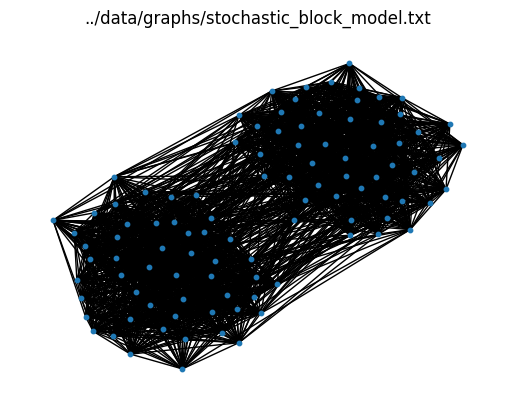

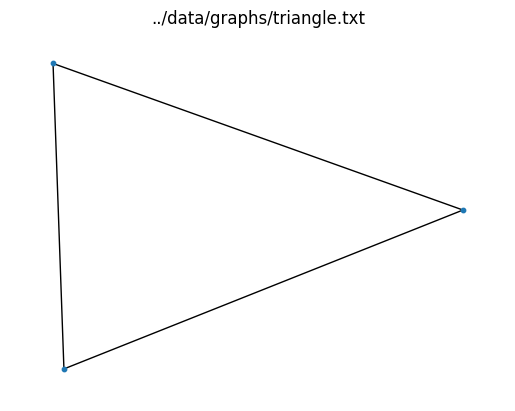

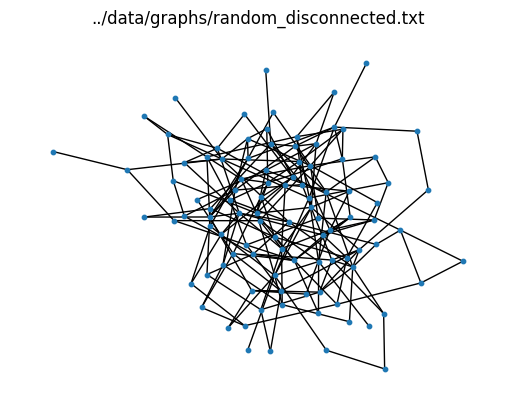

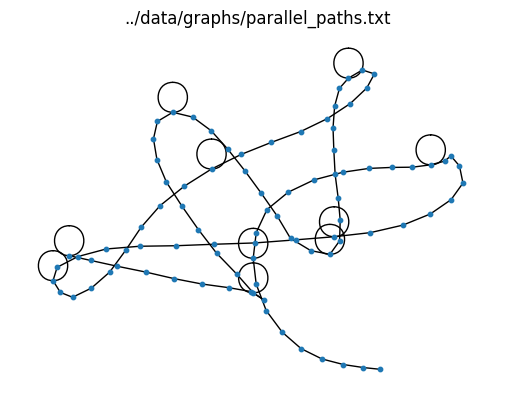

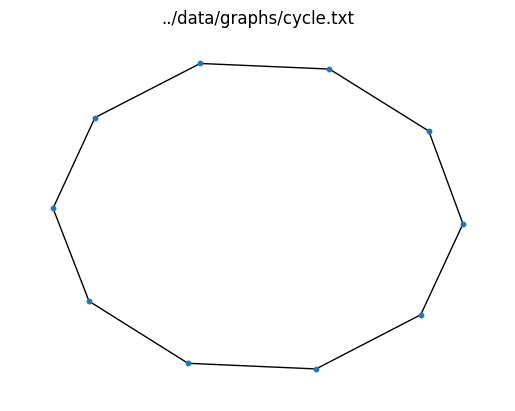

In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def load_networkx_edgelist(filepath: str) -> nx.Graph:
    """Load a networkx graph from an edgelist file"""
    return nx.read_edgelist(filepath, nodetype=int, create_using=nx.Graph)

def visualize_graph(input_graph_filepath) -> None:
    """Visualize a graph"""
    graph = load_networkx_edgelist(input_graph_filepath)
    fig, ax = plt.subplots()
    nx.draw(graph, ax=ax, node_size=10)
    ax.set_title(input_graph_filepath)
    plt.show()

input_graph_filepaths = [config.input_filepath for config in config_flattened]
input_graph_filepaths = list(set(input_graph_filepaths))

for input_graph_filepath in input_graph_filepaths:
    visualize_graph(input_graph_filepath)

## Visualize the embeddings

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Evaluating embedding: ../data/embeddings/triangle_fixed_i3_d10.txt
Using perplexity of 2 for t-SNE (num_nodes=3


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Evaluating embedding: ../data/embeddings/triangle_neighbourhood_depth_d10.txt
Using perplexity of 2 for t-SNE (num_nodes=3


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


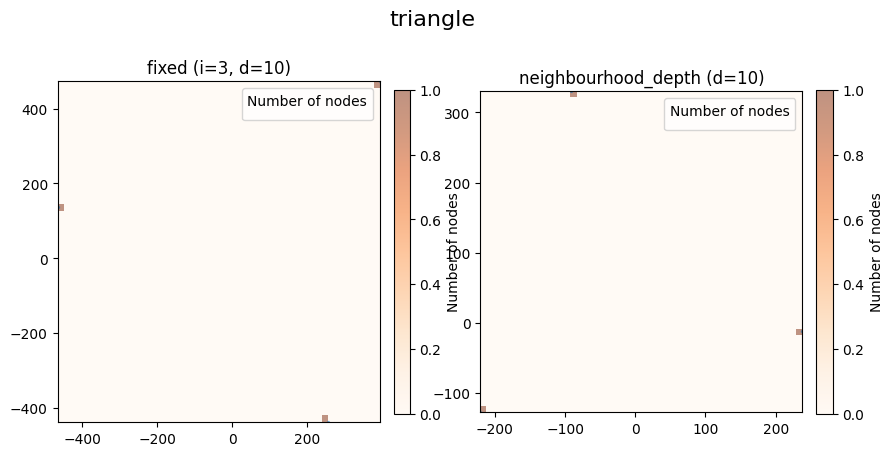

Evaluating embedding: ../data/embeddings/path_fixed_i3_d10.txt
Using perplexity of 2 for t-SNE (num_nodes=9


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Evaluating embedding: ../data/embeddings/path_neighbourhood_depth_d10.txt
Using perplexity of 2 for t-SNE (num_nodes=9


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


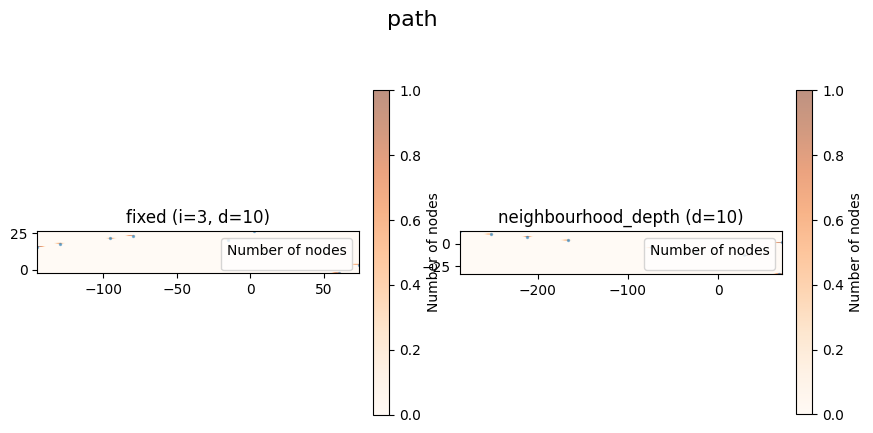

Evaluating embedding: ../data/embeddings/parallel_paths_fixed_i3_d10.txt
Using perplexity of 3 for t-SNE (num_nodes=90


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Evaluating embedding: ../data/embeddings/parallel_paths_neighbourhood_depth_d10.txt
Using perplexity of 3 for t-SNE (num_nodes=90


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


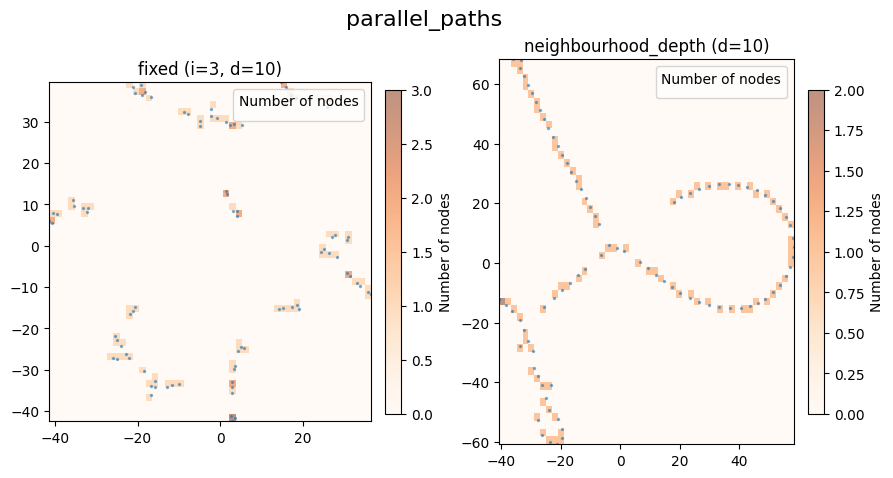

Evaluating embedding: ../data/embeddings/cycle_fixed_i3_d10.txt
Using perplexity of 2 for t-SNE (num_nodes=10


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Evaluating embedding: ../data/embeddings/cycle_neighbourhood_depth_d10.txt
Using perplexity of 2 for t-SNE (num_nodes=10


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


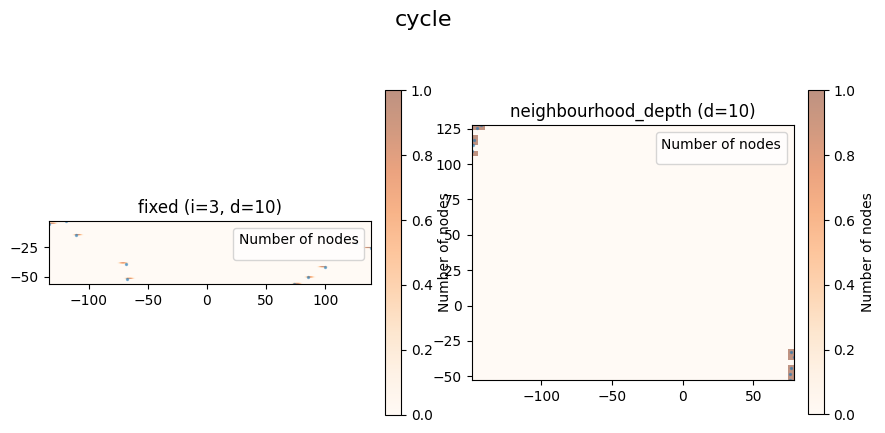

Evaluating embedding: ../data/embeddings/stochastic_block_model_fixed_i3_d10.txt
Using perplexity of 3 for t-SNE (num_nodes=100


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Evaluating embedding: ../data/embeddings/stochastic_block_model_neighbourhood_depth_d10.txt
Using perplexity of 3 for t-SNE (num_nodes=100


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


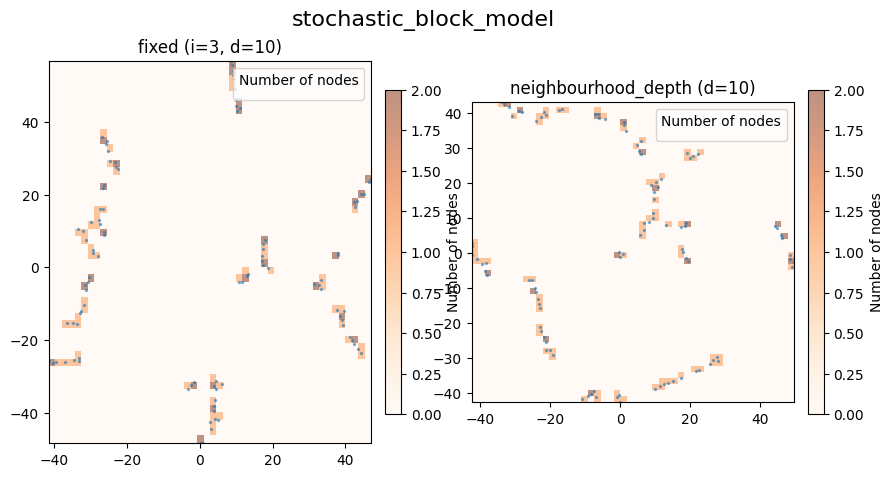

Evaluating embedding: ../data/embeddings/random_disconnected_fixed_i3_d10.txt
Using perplexity of 3 for t-SNE (num_nodes=99


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Evaluating embedding: ../data/embeddings/random_disconnected_neighbourhood_depth_d10.txt
Using perplexity of 3 for t-SNE (num_nodes=99


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


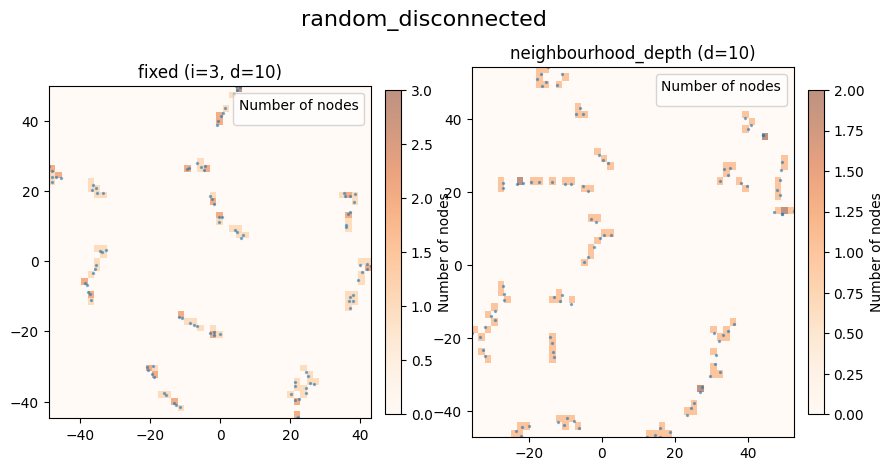

Evaluating embedding: ../data/embeddings/facebook_fixed_i1_d10.txt
Using perplexity of 134 for t-SNE (num_nodes=4039


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Evaluating embedding: ../data/embeddings/facebook_fixed_i1_d100.txt
Using perplexity of 134 for t-SNE (num_nodes=4039


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Evaluating embedding: ../data/embeddings/facebook_fixed_i7_d10.txt
Using perplexity of 134 for t-SNE (num_nodes=4039


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Evaluating embedding: ../data/embeddings/facebook_fixed_i7_d100.txt
Using perplexity of 134 for t-SNE (num_nodes=4039


/var/folders/hd/21lgsvy11w7dl28nc8cp4w6r0000gn/T/ipykernel_75259/1428566695.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
/Users/piotrpilis/Projects/Personal/wut-mini-computer-science/machine-learning-on-graphs/project/venv/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


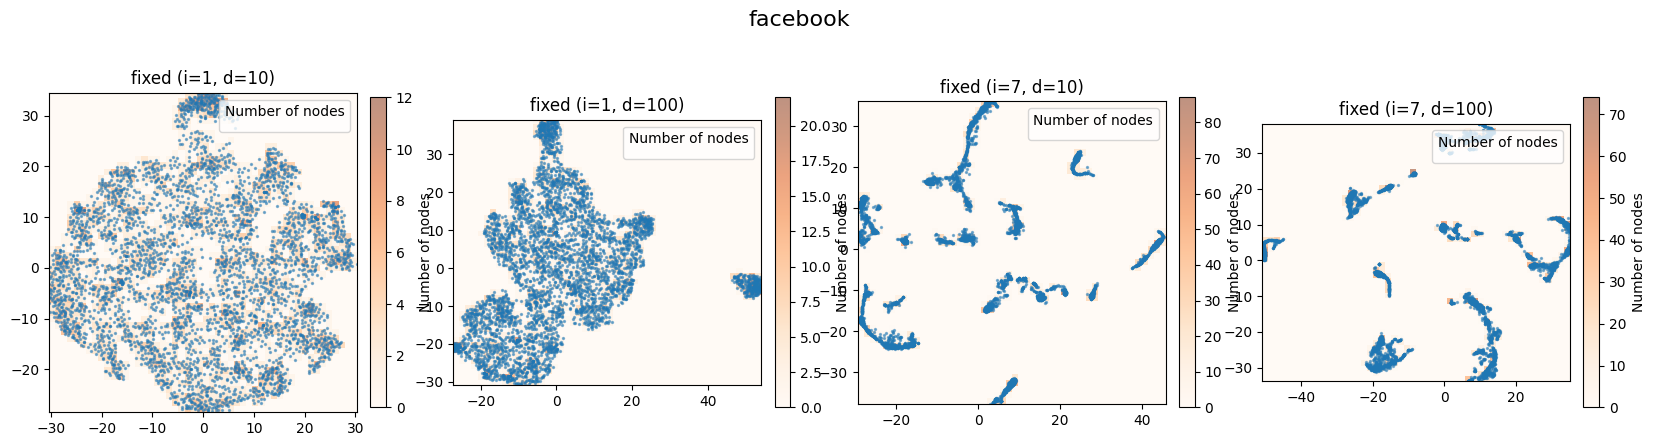

In [11]:
def load_numpy_2d_array_from_file(filepath):
    """Load a numpy 2d array from a file"""
    array = np.loadtxt(filepath, delimiter=" ")
    return array


def transform_embeddings_to_2d(embedding):
    """Transform multi-dimensional embeddings to 2d"""
    num_nodes = embedding.shape[0]
    perplexity = max(2, int(num_nodes / 30))
    print(f"Using perplexity of {perplexity} for t-SNE (num_nodes={num_nodes}")

    # First we reduce the dimensionality of the embedding using PCA
    embedding_pca = PCA(n_components=2).fit_transform(embedding)

    # Then we use t-SNE to visualize the embedding
    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
    embedding_2d = tsne.fit_transform(embedding_pca)

    return embedding_2d


def plot_embedding(embedding: np.ndarray, config, axes, idx) -> None:
    """Plot the embedding as a scatter plot with a heatmap overlay"""
    x = embedding[:, 0]
    y = embedding[:, 1]
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    axes[idx].set_facecolor('white')  # Set the background color to white
    sc = axes[idx].scatter(x, y, cmap="tab10", s=2, alpha=0.5)
    im = axes[idx].imshow(heatmap.T, cmap="Oranges", extent=extent, origin="lower", alpha=0.5)
    cbar = plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Number of nodes')  # Set the label for the colorbar
    axes[idx].set_title(f"{config.get_plot_label()}")
    axes[idx].legend(*sc.legend_elements(), loc="upper right", title="Number of nodes")  # Add legend


def evaluate(config: CleoraConfig, axes, idx) -> None:
    """Evaluate the embedding"""
    print(f"Evaluating embedding: {config.output_filepath}")
    embedding = load_numpy_2d_array_from_file(config.output_filepath)
    embedding_2d = transform_embeddings_to_2d(embedding)
    plot_embedding(embedding_2d, config, axes, idx)


for dataset_id, configs in CONFIGS.items():
    # Set up the figure
    num_configs = len(configs)
    fig, axes = plt.subplots(nrows=1, ncols=num_configs, figsize=(5 * num_configs, 5))

    # Give the figure a title
    fig.suptitle(dataset_id, fontsize=16)

    # Evaluate the embeddings and plot them
    for idx, config in enumerate(configs):
        evaluate(config, axes, idx)

    # Show the figure
    plt.show()